In [ ]:

import sys
sys.path.append('..')

import time
import jax
import jax.numpy as jnp
from nets.PerceiverIO import AttnConfig, PerceiverIO

# Create attention configs (simplified - removed unused params)
attn_cfg_cross = AttnConfig(
    num_heads=8,
    head_dim=64,
    num_kv_heads=8,
    use_qk_norm=True,
    dtype=jnp.float32
)

attn_cfg_self = AttnConfig(
    num_heads=4,
    head_dim=64,
    num_kv_heads=4,
    use_qk_norm=True,
    dtype=jnp.float32
)


# Create benchmark model
perceiver = PerceiverIO(
    num_latents=128,
    latent_dim=128,
    depth=4,
    attn_cfg_cross=attn_cfg_cross,
    attn_cfg_self=attn_cfg_self,
    ff_hidden=256,
    ff_dropout=0.0,
    dtype=jnp.float32,
    decoder_dim=512,
    decoder_heads=8,
    decoder_kv_heads=8,
    decoder_head_dim=64
)

rng = jax.random.PRNGKey(123)
# Initialize with small dummy tensors to build params
variables = perceiver.init(rng,
                             jnp.ones((1, 8, 64), dtype=jnp.float32),  # inputs
                             None,                                      # no pos
                             jnp.ones((1, 1, 512), dtype=jnp.float32),  # queries
                             deterministic=True)
params = variables['params']

# Benchmark shapes
B, N, Cin = 32, 8192, 64
M, Cq = 64, 512

key_in, key_q = jax.random.split(rng)
bench_inputs  = jax.random.normal(key_in, (B, N, Cin), dtype=jnp.float32)
bench_queries = jax.random.normal(key_q, (B, M, Cq), dtype=jnp.float32)

@jax.jit
def fwd(p, x, q):
    return perceiver.apply({'params': p}, x, None, q, deterministic=True)

# Warm-up / compile
_ = fwd(params, bench_inputs, bench_queries).block_until_ready()



In [ ]:
# jax mean on image height and width
import jax.numpy as jnp
import jax
from einops import rearrange, repeat, reduce
B,C,H,W = 16, 10, 30, 30
inputs = jax.random.normal(jax.random.PRNGKey(0), (B, C, H, W))

y1 = reduce(inputs, 'b c h w -> b c', 'mean')
y2 = jnp.mean(inputs, axis=(2,3))
y3 = jnp.einsum('b c h w -> b c', inputs)/(H*W)
y4 = inputs.sum(axis=(2,3))/(H*W)


In [ ]:
# jax split heads

B,N,H,D = 16,64,4,128
inputs = jax.random.normal(jax.random.PRNGKey(0), (B,N,H*D))

y1 = rearrange(inputs, 'b n (h d) -> b n h d', h=H)

In [ ]:


import jax
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_reduce
import operator
from nets.PerceiverIO import AttnConfig, PerceiverIO


# ARC-AGI Environment Test & Exploration

This notebook demonstrates how to use the ARC-AGI environment with the official ARC-AGI-2 dataset.

## Contents
1. Load and explore the dataset
2. Basic environment usage
3. Test new actions (erase, crop, move-to-origin)
4. Batched operations
5. Random agent baseline


In [52]:
# Setup: Import libraries
import sys
import os
sys.path.append('..')

# Force JAX to use CPU backend (Metal backend is experimental and has issues with complex JIT functions)
os.environ['JAX_PLATFORMS'] = 'cpu'

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from pathlib import Path
from PIL import Image
import io

from env import ARCEnv

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")


JAX version: 0.4.30
JAX devices: [CpuDevice(id=0)]


In [13]:
# Load a real ARC puzzle
puzzle_file = Path("../data/evaluation/e87109e9.json")
with open(puzzle_file, 'r') as f:
    puzzle_json = f.read()

# Create environment from puzzle
env = ARCEnv.from_json(puzzle_json, max_steps=50)
print(f"Loaded puzzle with {env.train_input.shape[0]} training examples and {env.test_input.shape[0]} test examples")


Loaded puzzle with 3 training examples and 1 test examples


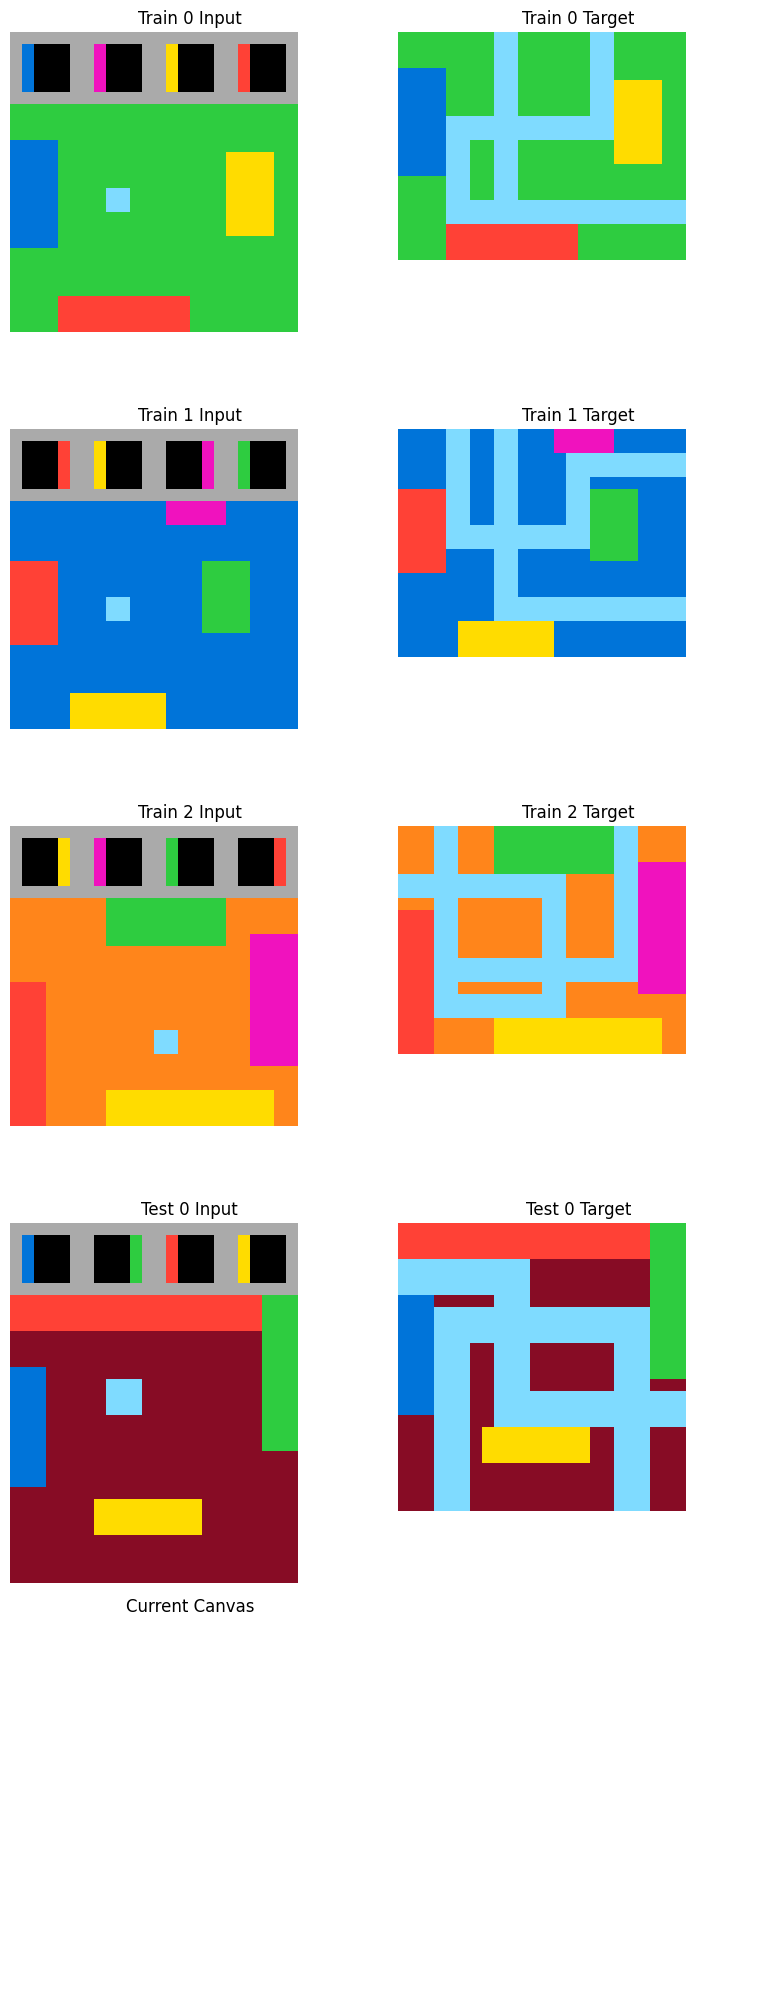

In [14]:
# Initialize environment
rng = jax.random.PRNGKey(42)
state = env.env_reset(rng, train=True)

# Render initial state
env.env_render(state, mode="all")


In [26]:
# Define a sequence of actions to demonstrate
# Let's copy from input and paint some cells
action_sequence = [
    (14, "Copy from input"),      # Copy at (0,0)
    (3, "Move right"),             # Move to (0,1)
    (3, "Move right"),             # Move to (0,2)
    (5, "Paint color 1 (blue)"),
    (2, "Move left"),              # Move to (1,1)
    (5, "Paint color 1 (blue)"),
    (2, "Move left"),              # Move to (1,0)
    (5, "Paint color 1 (blue)"),
]

print("Action sequence:")
for i, (action, desc) in enumerate(action_sequence):
    print(f"{i}: Action {action} - {desc}")


Action sequence:
0: Action 14 - Copy from input
1: Action 3 - Move right
2: Action 3 - Move right
3: Action 5 - Paint color 1 (blue)
4: Action 2 - Move left
5: Action 5 - Paint color 1 (blue)
6: Action 2 - Move left
7: Action 5 - Paint color 1 (blue)


In [51]:
# Helper function to render state to image array
def render_state_to_array(state, env, show_cursor=True):
    """Render a state to a numpy array suitable for GIF creation."""
    colours = [
        "#000000",  # 0 black
        "#0074D9",  # 1 blue
        "#FF4136",  # 2 red
        "#2ECC40",  # 3 green
        "#FFDC00",  # 4 yellow
        "#AAAAAA",  # 5 grey
        "#F012BE",  # 6 fuchsia
        "#FF851B",  # 7 orange
        "#7FDBFF",  # 8 light blue
        "#870C25",  # 9 burgundy
        "#FFFFFF",  # 10 placeholder for -1 (white)
    ]
    cmap = ListedColormap(colours)
    
    # Prepare grids
    def prep(arr):
        arr = np.array(arr, dtype=np.int32)
        return np.where(arr < 0, 10, arr)
    
    # Create figure with 3 subplots: input, canvas, target
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # Input
    axes[0].imshow(prep(state.inp), cmap=cmap, vmin=0, vmax=10)
    axes[0].set_title(f"Input (Step {int(state.steps)})")
    axes[0].axis("off")
    
    # Canvas with cursor
    canvas_display = prep(state.canvas)
    axes[1].imshow(canvas_display, cmap=cmap, vmin=0, vmax=10)
    if show_cursor:
        # Draw cursor as red square
        cursor_y, cursor_x = int(state.cursor[0]), int(state.cursor[1])
        axes[1].add_patch(plt.Rectangle((cursor_x-0.5, cursor_y-0.5), 1, 1, 
                                       fill=False, edgecolor='red', linewidth=3))
    axes[1].set_title(f"Canvas (Step {int(state.steps)})")
    axes[1].axis("off")
    
    # Target
    axes[2].imshow(prep(state.target), cmap=cmap, vmin=0, vmax=10)
    axes[2].set_title("Target")
    axes[2].axis("off")
    
    plt.tight_layout()
    
    # Convert to array
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    plt.close(fig)
    
    return np.array(img)


In [28]:
# Apply action sequence and collect frames
frames = []
current_state = state

# Add initial state
frames.append(render_state_to_array(current_state, env))

# Apply each action
total_reward = 0
for action, description in action_sequence:
    action_array = jnp.array(action, dtype=jnp.int32)
    current_state, reward, done = env.env_step(current_state, action_array)
    total_reward += float(reward)
    
    # Render and save frame
    frames.append(render_state_to_array(current_state, env))
    
    print(f"Applied: {description} | Reward: {reward:.1f} | Total: {total_reward:.1f} | Done: {done}")
    
    if done:
        print("Episode finished!")
        break

print(f"\nCollected {len(frames)} frames")


Applied: Copy from input | Reward: 0.0 | Total: 0.0 | Done: False
Applied: Move right | Reward: 0.0 | Total: 0.0 | Done: False
Applied: Move right | Reward: 0.0 | Total: 0.0 | Done: False
Applied: Paint color 1 (blue) | Reward: 0.0 | Total: 0.0 | Done: False
Applied: Move left | Reward: 0.0 | Total: 0.0 | Done: False
Applied: Paint color 1 (blue) | Reward: 0.0 | Total: 0.0 | Done: False
Applied: Move left | Reward: 0.0 | Total: 0.0 | Done: False
Applied: Paint color 1 (blue) | Reward: 0.0 | Total: 0.0 | Done: False

Collected 9 frames


In [29]:
# Create GIF from frames
output_path = Path("arc_action_sequence.gif")

# Convert frames to PIL Images
pil_frames = [Image.fromarray(frame) for frame in frames]

# Save as GIF
pil_frames[0].save(
    output_path,
    save_all=True,
    append_images=pil_frames[1:],
    duration=500,  # milliseconds per frame
    loop=0  # infinite loop
)

print(f"GIF saved to: {output_path}")
print(f"Duration: {len(frames) * 0.5:.1f} seconds")


GIF saved to: arc_action_sequence.gif
Duration: 4.5 seconds


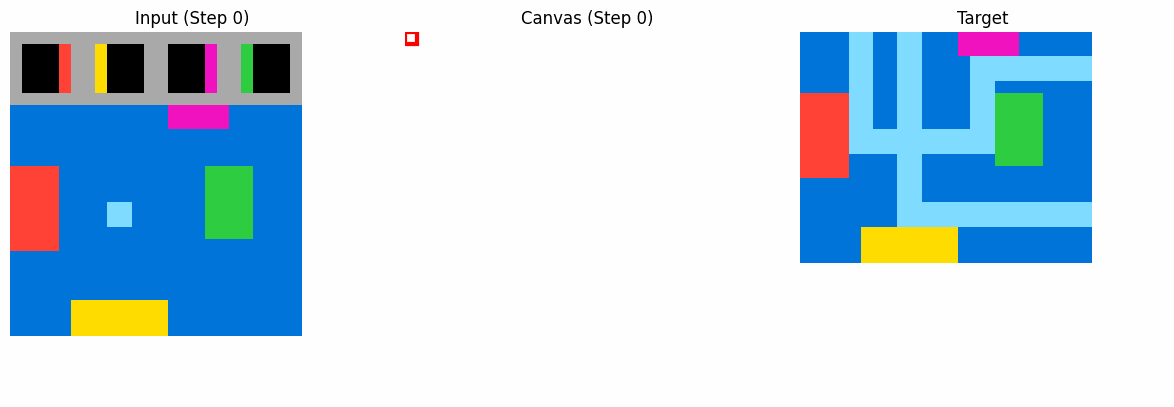

In [30]:
# Display the GIF in the notebook
from IPython.display import Image as IPImage, display

display(IPImage(filename=str(output_path)))


## More Complex Example: Using Different Actions

Let's try a different puzzle with more interesting actions including painting, cropping, and move-to-origin.


In [20]:
# Reset with a new seed
rng = jax.random.PRNGKey(123)
state = env.env_reset(rng, train=True)

# More complex action sequence with painting
action_sequence_2 = [
    (4, "Paint color 0 (black)"),
    (3, "Move right"),
    (5, "Paint color 1 (blue)"),
    (3, "Move right"),
    (6, "Paint color 2 (red)"),
    (1, "Move down"),
    (7, "Paint color 3 (green)"),
    (2, "Move left"),
    (8, "Paint color 4 (yellow)"),
    (2, "Move left"),
    (9, "Paint color 5 (grey)"),
]

# Execute and create GIF
frames_2 = [render_state_to_array(state, env)]
current_state = state

for action, description in action_sequence_2:
    action_array = jnp.array(action, dtype=jnp.int32)
    current_state, reward, done = env.env_step(current_state, action_array)
    frames_2.append(render_state_to_array(current_state, env))
    print(f"{description} | Cursor: ({int(current_state.cursor[0])}, {int(current_state.cursor[1])})")

# Save second GIF
output_path_2 = Path("arc_painting_example.gif")
pil_frames_2 = [Image.fromarray(frame) for frame in frames_2]
pil_frames_2[0].save(output_path_2, save_all=True, append_images=pil_frames_2[1:], 
                     duration=400, loop=0)
print(f"\nGIF saved to: {output_path_2}")


Paint color 0 (black) | Cursor: (0, 0)
Move right | Cursor: (0, 1)
Paint color 1 (blue) | Cursor: (0, 1)
Move right | Cursor: (0, 2)
Paint color 2 (red) | Cursor: (0, 2)
Move down | Cursor: (1, 2)
Paint color 3 (green) | Cursor: (1, 2)
Move left | Cursor: (1, 1)
Paint color 4 (yellow) | Cursor: (1, 1)
Move left | Cursor: (1, 0)
Paint color 5 (grey) | Cursor: (1, 0)

GIF saved to: arc_painting_example.gif


## Quick Reference: Action IDs

```python
# Movement
0: Move up
1: Move down
2: Move left
3: Move right

# Painting (4-13)
4-13: Paint colors 0-9 (action - 4 = color)

# Special actions
14: Copy from input grid
15: Erase (paint -1)
16: Crop (fill right and down with -1)
17: Move-to-origin (shift grid so cursor moves to 0,0)
```


In [21]:
from functools import partial
import jax
import jax.numpy as jnp
from jax import lax

def _neighbors4(mask: jnp.ndarray) -> jnp.ndarray:
    """Return 4-neighborhood of True pixels without wrap-around."""
    up    = jnp.pad(mask[1:, :],  ((0, 1), (0, 0)))
    down  = jnp.pad(mask[:-1, :], ((1, 0), (0, 0)))
    left  = jnp.pad(mask[:, 1:],  ((0, 0), (0, 1)))
    right = jnp.pad(mask[:, :-1], ((0, 0), (1, 0)))
    return up | down | left | right

def _neighbors8(mask: jnp.ndarray) -> jnp.ndarray:
    """Return 8-neighborhood of True pixels without wrap-around."""
    nb4 = _neighbors4(mask)
    ul = jnp.pad(mask[1:, 1:],  ((0, 1), (0, 1)))
    ur = jnp.pad(mask[1:, :-1], ((0, 1), (1, 0)))
    dl = jnp.pad(mask[:-1, 1:], ((1, 0), (0, 1)))
    dr = jnp.pad(mask[:-1, :-1],((1, 0), (1, 0)))
    return nb4 | ul | ur | dl | dr

@partial(jax.jit, static_argnames=('connectivity',))
def flood_fill(grid: jnp.ndarray,
               xy: jnp.ndarray,
               new_color: jnp.ndarray,
               *,
               connectivity: int = 4) -> jnp.ndarray:
    """
    JIT-friendly flood fill on a single HxW grid (e.g., 30x30) with labels 0..10.
    Args:
      grid:        [H, W] int array.
      xy:          [2] int array: (x, y) starting coords (column, row).
      new_color:   scalar int (0..10).
      connectivity: 4 or 8 (static).
    Returns:
      Filled grid with the connected component at (x,y) recolored to new_color.
    """
    grid = grid.astype(jnp.int32)
    H, W = grid.shape

    x = jnp.clip(xy[0], 0, W - 1)
    y = jnp.clip(xy[1], 0, H - 1)

    target = grid[y, x]
    same_color = (grid == target)

    seed = (jnp.arange(H)[:, None] == y) & (jnp.arange(W)[None, :] == x)

    if connectivity == 4:
        neighbors = _neighbors4
    else:
        neighbors = _neighbors8

    def cond_fn(state):
        visited, frontier = state
        return jnp.any(frontier)

    def body_fn(state):
        visited, frontier = state
        new_frontier = neighbors(frontier) & same_color & (~visited)
        visited = visited | new_frontier
        return (visited, new_frontier)

    visited, _ = lax.while_loop(cond_fn, body_fn, (seed, seed))
    return jnp.where(visited, jnp.asarray(new_color, grid.dtype), grid)


In [22]:
H = W = 30
rng = jax.random.PRNGKey(20)
grid = jax.random.randint(rng, shape=(H, W), minval=0, maxval=2, dtype=jnp.int32)

rng, key = jax.random.split(rng)
xy = jax.random.randint(key, shape=(2,), minval=0, maxval=30, dtype=jnp.int32)  # x, y

new_color = jnp.int32(5)

filled = flood_fill(grid, xy, new_color, connectivity=4)  # JIT-compiled on first call


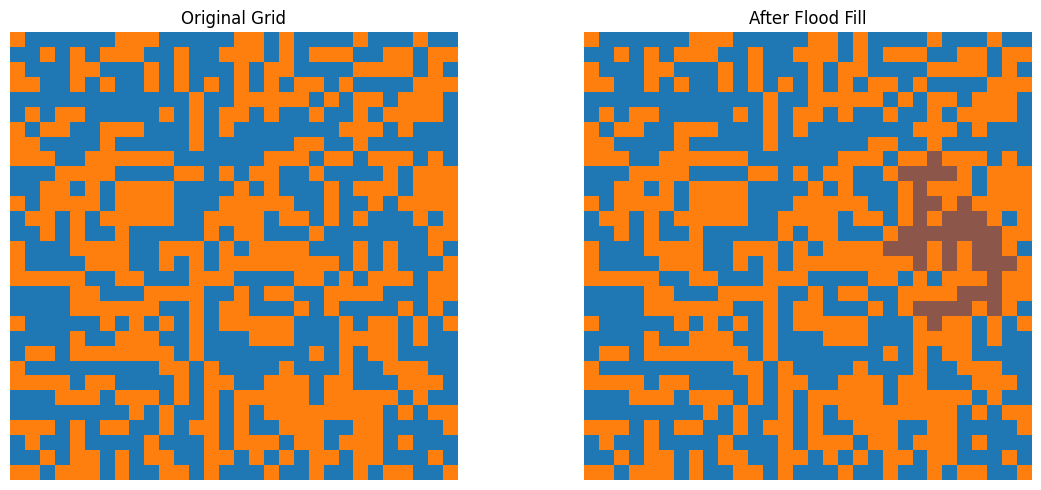

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(grid, cmap='tab20', vmin=0, vmax=10)
axes[0].set_title('Original Grid')
axes[0].axis('off')

axes[1].imshow(filled, cmap='tab20', vmin=0, vmax=10)
axes[1].set_title('After Flood Fill')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [24]:
from nets.PerceiverIO import PerceiverIO
perceiver = PerceiverIO()

In [25]:
# Count parameters in the Perceiver model
import jax
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_reduce
import operator
import importlib
import nets.PerceiverIO as perceiver_module

# Ensure we have the latest simplified module loaded
importlib.reload(perceiver_module)
from nets.PerceiverIO import AttnConfig, PerceiverIO

# Initialize the model with proper configuration
rng = jax.random.PRNGKey(0)

# Create attention configs (simplified - removed unused params)
attn_cfg_cross = AttnConfig(
    num_heads=8,
    head_dim=64,
    num_kv_heads=8,
    use_qk_norm=True,
    dtype=jnp.float32
)

attn_cfg_self = AttnConfig(
    num_heads=4,
    head_dim=64,
    num_kv_heads=4,
    use_qk_norm=True,
    dtype=jnp.float32
)

# Create Perceiver with explicit configs
perceiver = PerceiverIO(
    num_latents=128,
    latent_dim=128,
    depth=4,
    attn_cfg_cross=attn_cfg_cross,
    attn_cfg_self=attn_cfg_self,
    ff_hidden=256,
    ff_dropout=0.0,
    dtype=jnp.float32
)

dummy_inputs = jnp.ones((1, 100, 64))  # (batch, seq_len, input_dim)
dummy_input_pos = jnp.arange(100)[None, :, None]  # (batch, seq_len, 1)
dummy_queries = jnp.ones((1, 10, 512))  # (batch, num_queries, query_dim) - match decoder_dim

# Initialize parameters
@jax.jit
def init_fn(rng):
    return perceiver.init(rng, dummy_inputs, dummy_input_pos, dummy_queries, deterministic=True)

variables = init_fn(rng)
params = variables['params']

# Count total parameters
param_count = tree_reduce(
    operator.add,
    tree_map(lambda x: x.size, params)
)

print(f"Total number of parameters in Perceiver: {param_count:,}")


Total number of parameters in Perceiver: 2,808,320


## Model-Driven Rollout

Let's initialize the PerceiverActorCritic model, count its parameters, and run 100 steps where the model generates actions.



In [55]:
# Import the model
import sys, os
from pathlib import Path

sys.path.append('..')

from nets.PerceiverActorCritic import PerceiverActorCritic
from jax.tree_util import tree_map, tree_reduce
from dataclasses import replace
import operator
from env.env import ARCEnv


# Initialize environment with a puzzle
puzzle_file = Path("../data/evaluation/e87109e9.json")
with open(puzzle_file, 'r') as f:
    puzzle_json = f.read()

env = ARCEnv.from_json(puzzle_json, max_steps=100)
rng = jax.random.PRNGKey(488)
state = env.env_reset(rng, train=True)

# Initialize the PerceiverActorCritic model
model = PerceiverActorCritic()

# Prepare model inputs
def make_model_inputs(state):
    """Prepare model inputs (batch=1) from env state."""
    task_grids = jnp.stack([state.inp, state.target])[None, ...]  # (1, 2, 30, 30)
    grid_type_ids = jnp.array([[0, 1]], dtype=jnp.int32)
    canvas_grid = state.canvas[None, ...]  # (1, 30, 30)
    return task_grids, grid_type_ids, canvas_grid

# Initialize model parameters
task_grids, grid_type_ids, canvas_grid = make_model_inputs(state)
params = model.init(jax.random.PRNGKey(1), task_grids, grid_type_ids, canvas_grid)

# Count parameters
param_count = tree_reduce(
    operator.add,
    tree_map(lambda x: x.size, params['params'])
)
print(f"Total number of parameters in PerceiverActorCritic: {param_count:,}")

# Define policy function that samples actions
@jax.jit
def policy_fn(params, rng, task_grids, grid_ids, canvas):
    outputs = model.apply(params, task_grids, grid_ids, canvas, deterministic=True)
    pooled_logits = outputs["logits"].mean(axis=1)  # (B, policy_dim)
    actions = jax.random.categorical(rng, pooled_logits, axis=-1)
    return actions.astype(jnp.int32), outputs["value"]

# Run 100 steps with model generating actions
print(f"\nRunning 100 steps with model-generated actions...")
frames = [render_state_to_array(state, env)]
current_state = state
total_reward = 0

for step in range(100):
    # Get model action
    task_grids, grid_ids, canvas = make_model_inputs(current_state)
    state_rng, action_rng = jax.random.split(current_state.rng)
    current_state = replace(current_state, rng=state_rng)
    actions, values = policy_fn(params, action_rng, task_grids, grid_ids, canvas)
    action = int(actions[0])
    
    # Step environment
    current_state, reward, done = env.env_step(current_state, jnp.array(action, dtype=jnp.int32))
    total_reward += float(reward)
    
    # Render frame
    frames.append(render_state_to_array(current_state, env))
    
    if bool(done):
        print(f"Episode finished at step {step + 1}")
        break

print(f"Total steps: {len(frames) - 1}")
print(f"Total reward: {total_reward}")

# Create GIF
output_path = Path("arc_model_rollout.gif")
pil_frames = [Image.fromarray(frame) for frame in frames]
pil_frames[0].save(
    output_path,
    save_all=True,
    append_images=pil_frames[1:],
    duration=100,  # milliseconds per frame (faster since we have 100 frames)
    loop=0
)

print(f"\nGIF saved to: {output_path}")
print(f"Duration: {len(frames) * 0.1:.1f} seconds")



Total number of parameters in PerceiverActorCritic: 58,811,411

Running 100 steps with model-generated actions...
Episode finished at step 17
Total steps: 17
Total reward: 0.0

GIF saved to: arc_model_rollout.gif
Duration: 1.8 seconds


In [ ]:
# Display the GIF in the notebook
from IPython.display import Image as IPImage, display

display(IPImage(filename=str(output_path)))

